In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Chargement des librairies

In [ ]:
%pip install pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os 

import matplotlib.pyplot as plt
import numpy as np 
import nrrd as nd
import pandas as pd 
import random 
import tensorflow as tf


from tqdm import tqdm_notebook, tnrange
import matplotlib.patches as mpatches
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from pydicom import dcmread 
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import *
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import image
from tensorflow.keras import backend as K
from enum import Enum
from PIL import Image

# Constantes

In [ ]:
INPUTS_PATH = "/content/drive/MyDrive/Segmentation sémantique/Inputs"
OUTPUTS_PATH = "/content/drive/MyDrive/Segmentation sémantique/Outputs"

# La taille de l'image doit etre multiple de 16 parce que la première couche de convolution à des filtres de taille 16
IMAGE_HEIGHT = 192
IMAGE_WIDHT = 192

NUM_CLASSES = 3

# Fonctions

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [ ]:
def get_unet(input_img, n_filters = 32, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(NUM_CLASSES, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs], name="U-net")
    return model

In [ ]:
def encode_inputs(img):
  """
  """
  img = np.squeeze(img)
  for x,y in [(x,y) for x in range(img.shape[0]) for y in range(img.shape[1])]:
      j = img[x,y]
      if j > 255:
        img[x,y] = 255
  return img

In [ ]:
def encode_masks(img, img_int):
    """
    Encode img for each class

    Parameters:
    ----------
    img (np.array): image array

    Return:
    ------
    mask (np.array)
    """
    img = np.squeeze(img).T
    img_int = np.squeeze(img_int) * 255

    for x,y in [(x,y) for x in range(img_int.shape[0]) for y in range(img_int.shape[1])]:
        j = img_int[x,y]
        if j > 255:
          img_int[x,y] = 255
        elif j in range(1,16):
          img_int[x,y] = 0
        else:
          img_int[x,y] = img_int[x,y] 

    
    dim = len(img.shape)
    if dim == 2:
      # on ramène toutes les valeurs de pixel représentant le foie (1,4) à 1 pour que après le resize on puisse différencier la lésion qui aura pour valeur de pixel 2
      for x,y in [(x,y) for x in range(img.shape[0]) for y in range(img.shape[1])]:
              j = img[x,y]
              if j == 4 or j == 1:
                img[x,y] = 1
              else:
                img[x,y] = img[x,y] 
      img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDHT), Image.NEAREST, mode = 'constant', preserve_range = True)

      mask = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
      mask[:, :, 0] = img_int
      # mask[:, :, 1] = img_int
      # mask[:, :, 2] = img_int
      # mask[:, :, 3] = img_int

      for x,y in [(x,y) for x in range(img.shape[0]) for y in range(img.shape[1])]:
        j = img[x,y]
        if j == 0:
          k = 0
        elif j < 2 and j > 0:
          k = 1
        elif j >=2:
          k = 2



        # Vide
        # if k == 0:
        #   mask[x, y, 0] = 0
        #   mask[x, y, 1] = 0
        #   mask[x, y, 2] = 0
        # Lésion
        if k > 1:
          mask[x, y, 0] = 0
          mask[x, y, 1] = 0
          mask[x, y, 2] = 1
          # mask[x, y, 3] = 0
        # Foie
        elif k == 1:
          mask[x, y, 0] = 0
          mask[x, y, 1] = 1
          mask[x, y, 2] = 0
          # mask[x, y, 3] = 0

    elif dim == 3:
      mask = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
      mask[:, :, 0] = img_int
      # mask[:, :, 1] = img_int
      # mask[:, :, 2] = img_int
      # mask[:, :, 3] = img_int
      
      # on ramène toutes les valeurs de pixel représentant le foie (1,4) à 1 pour que après le resize on puisse différencier la lésion qui aura pour valeur de pixel 2
      for x,y in [(x,y) for x in range(img.shape[1]) for y in range(img.shape[2])]:
        j = img[0,x,y]
        p = img[1,x,y]
        j += p
        if j == 4 or j == 1:
          img[0,x,y] = 0
          img[1,x,y] = 1
        else:
          img[0,x,y] = img[0,x,y]
          img[1,x,y] = img[1,x,y]
      img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDHT), Image.NEAREST, mode = 'constant', preserve_range = True)

      for x,y in [(x,y) for x in range(img.shape[1]) for y in range(img.shape[2])]:
        j = img[0,x,y]
        p = img[1,x,y]
        j += p

        if j == 0:
          k = 0
        elif j <2  and j > 0:
          k = 1
        elif j >=2:
          k = 2

        # Vide
        # if k == 0:
        #   mask[x, y, 0] = 0
        #   mask[x, y, 1] = 0
        #   mask[x, y, 2] = 0
        # Lésion
        if k > 1:
          mask[x, y, 0] = 0
          mask[x, y, 1] = 0
          mask[x, y, 2] = 1
          # mask[x, y, 3] = 0
        # Foie
        elif k == 1:
          mask[x, y, 0] = 0
          mask[x, y, 1] = 1
          mask[x, y, 2] = 0
          # mask[x, y, 3] = 0
    mask /= 255
    return mask

In [ ]:
def encode_preds(img):
    """
    Encode img_final pred for each class
    black for nothing
    green for the liver
    purple for the lesion 
    red for the rib cage section
    
    Parameters:
    ----------
    img (np.array): image array

    Return:
    ------
    img_final (np.array)
    """
    img = img * 255
    img = img.astype(int)
    for x,y in [(x,y) for x in range(img.shape[0]) for y in range(img.shape[1])]:
          j = img[x,y,0]
          if j > 15:
            img[x,y,0] = 1
          else:
            img[x,y,0] = 0

    img_final = np.zeros((img.shape[0], img.shape[1], 3))
    for x,y in [(x,y) for x in range(img.shape[0]) for y in range(img.shape[1])]:
      if img[x,y,0] == 0 and img[x,y,1] == 1 and img[x,y,2] == 0:
      # if img[x,y,0] == 2:
        img_final[x,y,0] = 104
        img_final[x,y,1] = 255
        img_final[x,y,2] = 51
      elif img[x,y,0] == 0 and img[x,y,1] == 0 and img[x,y,2] == 1:
      # elif img[x,y,0] == 3:
        img_final[x,y,0] = 138
        img_final[x,y,1] = 51
        img_final[x,y,2] = 255
      elif img[x,y,0] == 1 and img[x,y,1] == 0 and img[x,y,2] == 0:
      # elif img[x,y,0] == 1:
        img_final[x,y,0] =  49
        img_final[x,y,1] =  79
        img_final[x,y,2] =  79
    return img_final / 255

In [ ]:
def jacard_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

In [ ]:
def plot_sample(X, y, preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(1, len(X)) -1

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(X[ix, ..., 0], cmap=plt.cm.gray)
    ax[0].set_title('X')

    ax[1].imshow(encode_preds(y[ix]).squeeze(), cmap=plt.cm.gray, interpolation='nearest')
    ax[1].set_title('Y')

    ax[2].imshow(encode_preds(preds[ix]).squeeze(), cmap=plt.cm.gray, interpolation='nearest')
    ax[2].set_title('Predicted')
    
    colors = ['green','purple', 'darkslategray']

    labels = ["foie", "lésion", "cage"]

    patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

    plt.legend(
                handles=patches,
                bbox_to_anchor=(1.1, 0.65),
                loc=2,
                borderaxespad=0.4,
                fontsize=14,
                title="Mask Labels",
                title_fontsize=14,
                edgecolor="black",
                facecolor="#c5c6c7",
            )

# Exploration des données

## Création d'une dataframe à partir de listes

In [ ]:
list_patient = []
list_input = []
list_output = []
list_input_resized_scaled = []
list_output_resized_scaled = []
list_input_shape = []
list_output_shape = []
list_number_coupe = []
list_indice_coupe = []
list_number_distinct_pixel_output = []
patient_number = 1
for file in os.listdir(INPUTS_PATH):
  path_output = OUTPUTS_PATH + '/Patient ' + file +'.nrrd'
  path_input_dir = INPUTS_PATH + '/'+ file
  data, header = nd.read(path_output)
  number_coupe = data.shape[-1] 
  dim_output = len(data.shape)
  
  if number_coupe < 61:
    # continue

    print("\nPatient n°: ", patient_number)
    print("Processing données patient n°: ", file)
    print("Dimension de l'image", data.shape)
    print(f'{number_coupe} coupes')
    patient_number +=1

    if dim_output == 3:
        for coupe in range(number_coupe):
          print(f'Coupe n°: {coupe + 1}')
          for input in os.listdir(path_input_dir):
              if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
                path_input = path_input_dir + '/' + input
                input = dcmread(path_input).pixel_array
                list_input.append(input)
                list_input_shape.append(input.shape)

                input_resized_scaled = (resize(encode_inputs(input), (IMAGE_HEIGHT, IMAGE_WIDHT, 1), Image.NEAREST, mode = 'constant', preserve_range = True)) / 255
                list_input_resized_scaled.append(input_resized_scaled)
                
                output = (data[:, :, coupe]).T
                list_number_distinct_pixel_output.append(np.unique(output, return_counts=True)[0].shape[0])
                list_output.append(output)
                list_output_shape.append(output.shape)

                output_resized_scaled = encode_masks(data[:, :, coupe], input_resized_scaled)
                list_output_resized_scaled.append(output_resized_scaled)
                list_patient.append(file)
                list_number_coupe.append(number_coupe)
                list_indice_coupe.append(coupe+1)

    elif dim_output != 3:

        for coupe in range(number_coupe):
          print(f'Coupe n°: {coupe + 1}')
          for input in os.listdir(path_input_dir):
              if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
                path_input = path_input_dir + '/' + input
                input = dcmread(path_input).pixel_array
                list_input.append(input)
                list_input_shape.append(input.shape)

                input_resized_scaled = (resize(encode_inputs(input), (IMAGE_HEIGHT, IMAGE_WIDHT, 1), Image.NEAREST, mode = 'constant', preserve_range = True)) / 255
                list_input_resized_scaled.append(input_resized_scaled)
                
                data[1, :, :, coupe] = data[0, :, :, coupe] + data[1, :, :, coupe]
                output = (data[1, :, :, coupe]).T
                list_number_distinct_pixel_output.append(np.unique(output, return_counts=True)[0].shape[0])
                list_output.append(output)
                list_output_shape.append(data[:, :, :, coupe].shape)

                output_resized_scaled = (encode_masks(data[1, :, :, coupe], input_resized_scaled))
                list_output_resized_scaled.append(output_resized_scaled)
                list_patient.append(file)
                list_number_coupe.append(number_coupe)
                list_indice_coupe.append(coupe+1)
    print("Fini")             

In [ ]:
len(list_patient), len(list_input), len(list_input_shape), len(list_output), len(list_number_distinct_pixel_output), len(list_output_shape), \
len(list_indice_coupe), len(list_number_coupe), len(list_output_resized_scaled), len(list_input_resized_scaled)

(1113, 1113, 1113, 1113, 1113, 1113, 1113, 1113, 1113, 1113)

In [ ]:
df = pd.DataFrame({"Patients": list_patient,
                   "Inputs": list_input,
                   "Outputs": list_output,
                   "Number_distincts_pixel_output": list_number_distinct_pixel_output,
                   "Input_shape": list_input_shape,
                   "Outputs_shape": list_output_shape,
                   "Indices_coupe": list_indice_coupe,
                  "Number_coupe": list_number_coupe,
                  "Inputs_resized_scaled": list_input_resized_scaled,
                  "Outputs_resized_scaled": list_output_resized_scaled
                  })

df["Patients"] = df["Patients"].astype(int)
df = df.sort_values(by=["Patients", "Indices_coupe"], ignore_index=True)
df

## Visualisation des données

In [ ]:
# 100 premières coupes
for indice_patient in range(len(df[:100])):
# for indice_patient in range(len(df)):
  coupe = df.loc[indice_patient, "Indices_coupe"]
  dim_output = df.loc[indice_patient, "Outputs_shape"]
  print("\n----------------------------------------------------------------------------------------------------------------------------------------------------------------\n----------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print("Patient: ", df.loc[indice_patient, "Patients"])
  print("Nombre de coupe: ", df.loc[indice_patient, "Number_coupe"])
  print("Coupe n°: ", coupe)
  print("Output shape: ", df.loc[indice_patient, "Outputs_shape"])

  input = df.loc[indice_patient, "Inputs"]

  print("Input shape: ", input.shape)
  # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
  # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 1)
  plt.imshow(input, cmap=plt.cm.gray)
  plt.title("Input")

  output = df.loc[indice_patient, "Outputs"]
  # On regarde la distribution des pixels
  intensity_pixel_output = {}
  uniques,counts = np.unique(output,return_counts=True)
  pixel_output = dict(zip( uniques,counts))
  for key,value in pixel_output.items():
    try:
      intensity_pixel_output[key] += value
    except KeyError :
      intensity_pixel_output[key] = value
  intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 6)
  plt.title("Distribution des pixels")
  plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

  print("Nombre de valeurs distinctes de pixel Mask: ", np.unique(output,return_counts=True)[0].shape[0])
  print("Valeurs distinctes de pixel Mask: ", np.unique(output,return_counts=True)[0])
  # print("Valeurs distinctes de pixel output: ", np.unique(output,return_counts=True))
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 2)
  plt.imshow(output, cmap=plt.cm.gray)
  plt.title("Mask")

  # Après resize
  output = resize(output, (IMAGE_HEIGHT, IMAGE_WIDHT), Image.NEAREST, mode = 'constant', preserve_range = True)
  # On regarde la distribution des pixels
  intensity_pixel_output = {}
  uniques,counts = np.unique(output,return_counts=True)
  pixel_output = dict(zip( uniques,counts))
  for key,value in pixel_output.items():
    try:
      intensity_pixel_output[key] += value
    except KeyError :
      intensity_pixel_output[key] = value
  intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 7)
  plt.title("Distribution des pixels")
  plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

  print("Nombre de valeurs distinctes de pixel mask après resize: ", np.unique(output,return_counts=True)[0].shape[0])
  print("Valeurs distinctes de pixel mask après resize: ", np.unique(output,return_counts=True)[0])
  # print("Valeurs distinctes de pixel mask après resize: ", np.unique(output,return_counts=True))
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 3)
  plt.imshow(output, cmap=plt.cm.gray)
  plt.title("Mask après resize")

  # final
  output = encode_preds(df.loc[indice_patient, "Outputs_resized_scaled"])
  # On regarde la distribution des pixels
  intensity_pixel_output = {}
  uniques,counts = np.unique(output,return_counts=True)
  pixel_output = dict(zip( uniques,counts))
  for key,value in pixel_output.items():
    try:
      intensity_pixel_output[key] += value
    except KeyError :
      intensity_pixel_output[key] = value
  intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 8)
  plt.title("Distribution des pixels")
  plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

  print("Nombre de valeurs distinctes de pixel Output: ", np.unique(output,return_counts=True)[0].shape[0])
  # print("Valeurs distinctes de pixel Output: ", np.unique(output,return_counts=True)[0])
  # print("Valeurs distinctes de pixel Output: ", np.unique(output,return_counts=True))
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 4)
  plt.imshow(output, interpolation='nearest')
  plt.title("Output")

  colors = ['green','purple', 'darkslategray']

  labels = ["foie", "lésion", "cage"]

  patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

  plt.legend(
              handles=patches,
              bbox_to_anchor=(1.1, 0.65),
              loc=2,
              borderaxespad=0.4,
              fontsize=14,
              title="Mask Labels",
              title_fontsize=14,
              edgecolor="black",
              facecolor="#c5c6c7",
          )

  plt.show()

In [ ]:
file = 25
path_output = OUTPUTS_PATH + '/Patient ' + str(file) +'.nrrd'
path_input_dir = INPUTS_PATH + '/'+ str(file)
data, header = nd.read(path_output)
number_coupe = data.shape[-1] 
dim_output = len(data.shape)
# Chaque patient a différent coupe donc on va parcourir les coupes en entrées et en sorties pour chaque patient en faisant la correspondance entre les deux
for coupe in range(number_coupe):
  print("\n----------------------------------------------------------------------------------------------------------------------------------------------------------------\n----------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print("Patient: ", file)
  print("Nombre de coupe: ", number_coupe)
  print("Coupe n°: ", coupe+1)
  print("Output shape: ", data.shape)
  
  for input in os.listdir(path_input_dir):
      if dim_output == 3:
        if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
          path_input = path_input_dir + '/' + input
          input = dcmread(path_input).pixel_array

          print("Input shape: ", input.shape)
          # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
          # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 1)
          plt.imshow(input, cmap=plt.cm.gray)
          plt.title("Input")

          output = data[:, :, coupe].T
          # On regarde la distribution des pixels
          intensity_pixel_output = {}
          uniques,counts = np.unique(output,return_counts=True)
          pixel_output = dict(zip( uniques,counts))
          for key,value in pixel_output.items():
            try:
              intensity_pixel_output[key] += value
            except KeyError :
              intensity_pixel_output[key] = value
          intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 4)
          plt.title("Distribution des pixels")
          plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

          print("Nombre de valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0].shape[0])
          print("Valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0])
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 2)
          plt.imshow(output, cmap=plt.cm.gray)
          plt.title("Mask")

          
        
          

      elif dim_output != 3:
          if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
            path_input = path_input_dir + '/' + input
            input = dcmread(path_input).pixel_array

            print("Input shape: ", input.shape)
            # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
            # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 1)
            plt.imshow(input, cmap=plt.cm.gray)
            plt.title("Input")

          
            data[1, :, :, coupe] = data[0, :, :, coupe] + data[1, :, :, coupe]
            output = data[1, :, :, coupe].T
            # On regarde la distribution des pixels
            intensity_pixel_output = {}
            uniques,counts = np.unique(output,return_counts=True)
            pixel_output = dict(zip( uniques,counts))
            for key,value in pixel_output.items():
              try:
                intensity_pixel_output[key] += value
              except KeyError :
                intensity_pixel_output[key] = value
            intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 4)
            plt.title("Distribution des pixels")
            plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))
            # On regarde la distribution des pixels
            print("Nombre de valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0].shape[0])
            print("Valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0])
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 2)
            plt.imshow(output, cmap=plt.cm.gray)
            plt.title("Mask")
          

      
      plt.show()

In [ ]:
file = 40
path_output = OUTPUTS_PATH + '/Patient ' + str(file) +'.nrrd'
path_input_dir = INPUTS_PATH + '/'+ str(file)
data, header = nd.read(path_output)
number_coupe = data.shape[-1] 
dim_output = len(data.shape)
# Chaque patient a différent coupe donc on va parcourir les coupes en entrées et en sorties pour chaque patient en faisant la correspondance entre les deux
for coupe in range(number_coupe):
  print("\n----------------------------------------------------------------------------------------------------------------------------------------------------------------\n----------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print("Patient: ", file)
  print("Nombre de coupe: ", number_coupe)
  print("Coupe n°: ", coupe+1)
  print("Output shape: ", data.shape)
  
  for input in os.listdir(path_input_dir):
      if dim_output == 3:
        if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
          path_input = path_input_dir + '/' + input
          input = dcmread(path_input).pixel_array

          print("Input shape: ", input.shape)
          # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
          # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 1)
          plt.imshow(input, cmap=plt.cm.gray)
          plt.title("Input")

          output = data[:, :, coupe].T
          # On regarde la distribution des pixels
          intensity_pixel_output = {}
          uniques,counts = np.unique(output,return_counts=True)
          pixel_output = dict(zip( uniques,counts))
          for key,value in pixel_output.items():
            try:
              intensity_pixel_output[key] += value
            except KeyError :
              intensity_pixel_output[key] = value
          intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 4)
          plt.title("Distribution des pixels")
          plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

          print("Nombre de valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0].shape[0])
          print("Valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0])
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 2)
          plt.imshow(output, cmap=plt.cm.gray)
          plt.title("Mask")

      
          

      elif dim_output != 3:
          if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
            path_input = path_input_dir + '/' + input
            input = dcmread(path_input).pixel_array

            print("Input shape: ", input.shape)
            # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
            # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 1)
            plt.imshow(input, cmap=plt.cm.gray)
            plt.title("Input")

         
            data[1, :, :, coupe] = data[0, :, :, coupe] + data[1, :, :, coupe]
            output = data[1, :, :, coupe].T
            # On regarde la distribution des pixels
            intensity_pixel_output = {}
            uniques,counts = np.unique(output,return_counts=True)
            pixel_output = dict(zip( uniques,counts))
            for key,value in pixel_output.items():
              try:
                intensity_pixel_output[key] += value
              except KeyError :
                intensity_pixel_output[key] = value
            intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 4)
            plt.title("Distribution des pixels")
            plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))
            # On regarde la distribution des pixels
            print("Nombre de valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0].shape[0])
            print("Valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0])
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 2)
            plt.imshow(output, cmap=plt.cm.gray)
            plt.title("Mask")

      
      plt.show()

# Constitution de la base de donnée train et test

In [ ]:
X = df["Inputs_resized_scaled"]
len(X)

1113

In [ ]:
Y = df["Outputs_resized_scaled"]
len(Y)

1113

In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(np.array([np.array(x) for x in X]), np.array([np.array(y) for y in Y]), test_size=0.2)

In [ ]:
X_train.shape, y_valid.shape

((890, 192, 192, 1), (223, 192, 192, 3))

# Entrainement du modèle

In [ ]:
input_img = Input((IMAGE_HEIGHT, IMAGE_WIDHT, 1), name='img')


model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", dice_coef, jacard_coef])

In [ ]:
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 192, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 192, 192, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=15, restore_best_weights=True, verbose=1, mode="max"),
    ReduceLROnPlateau(monitor='val_jacard_coef', factor=0.1, patience=15, min_lr=0.00001, verbose=1),
    # ModelCheckpoint('/content/drive/MyDrive/model.h5', monitor='val_jacard_coef', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
]

In [27]:
# data_gen = ImageDataGenerator(
#     rotation_range=60,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     brightness_range=[0.2,1.0],
#     zoom_range=[1,0.5],
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     )

# data_gen.fit(X_train, augment=True, rounds=5, seed=1234)


# results = model.fit(data_gen.flow(X_train, y_train, batch_size=160), epochs=80, callbacks=callbacks,\
#                     validation_data=(X_valid, y_valid))



results = model.fit(X_train, y_train, batch_size=16, epochs=90, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/90
56/56 [==============================] - 258s 5s/step - loss: 0.3546 - accuracy: 0.3403 - dice_coef: 0.3210 - jacard_coef: 0.1931 - val_loss: 0.3415 - val_accuracy: 0.4391 - val_dice_coef: 0.3778 - val_jacard_coef: 0.2335 - lr: 0.0010
Epoch 2/90
56/56 [==============================] - 254s 5s/step - loss: 0.2098 - accuracy: 0.3626 - dice_coef: 0.4323 - jacard_coef: 0.2763 - val_loss: 0.2492 - val_accuracy: 0.3713 - val_dice_coef: 0.4258 - val_jacard_coef: 0.2711 - lr: 0.0010
Epoch 3/90
56/56 [==============================] - 256s 5s/step - loss: 0.1508 - accuracy: 0.3743 - dice_coef: 0.5156 - jacard_coef: 0.3480 - val_loss: 0.1657 - val_accuracy: 0.3616 - val_dice_coef: 0.5297 - val_jacard_coef: 0.3611 - lr: 0.0010
Epoch 4/90
56/56 [==============================] - 254s 5s/step - loss: 0.1179 - accuracy: 0.3842 - dice_coef: 0.5870 - jacard_coef: 0.4160 - val_loss: 0.1296 - val_accuracy: 0.3658 - val_dice_coef: 0.5646 - val_jacard_coef: 0.3944 - lr: 0.0010
Epoch 5/90
56/56

In [28]:
model.save('/content/drive/MyDrive/Segmentation sémantique/model.h5')

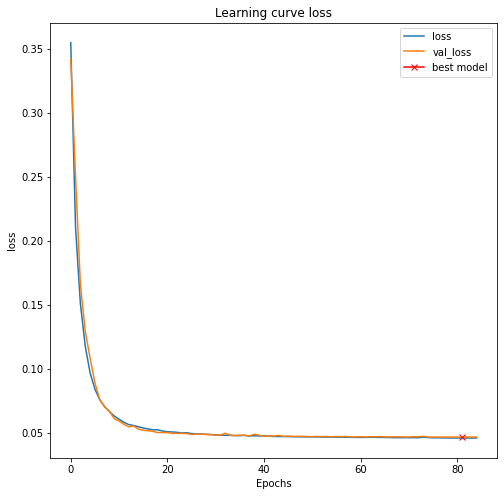

In [29]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve loss")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

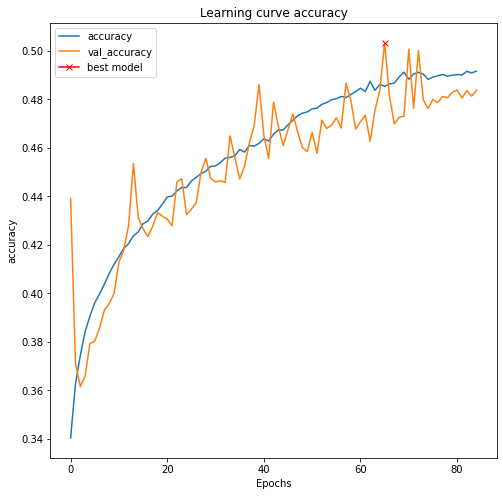

In [30]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve accuracy")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();

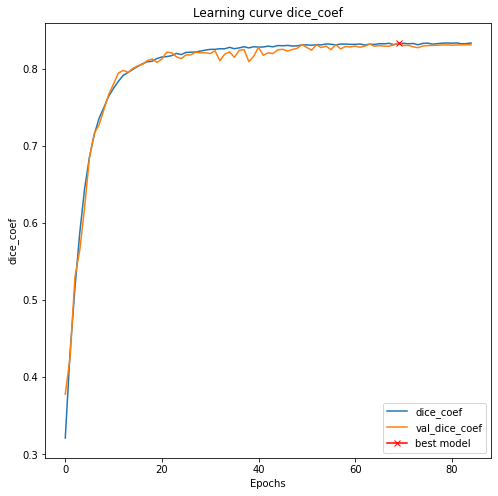

In [31]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve dice_coef")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

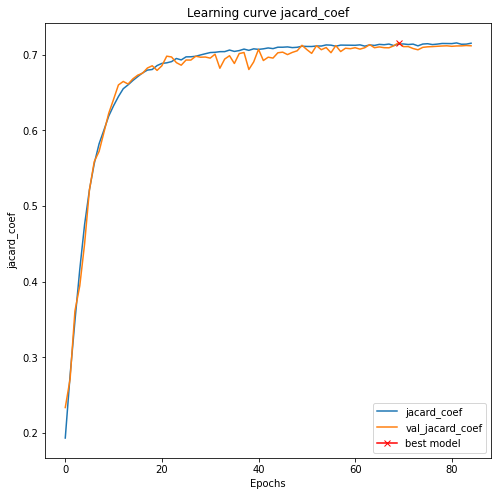

In [32]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve jacard_coef")
plt.plot(results.history["jacard_coef"], label="jacard_coef")
plt.plot(results.history["val_jacard_coef"], label="val_jacard_coef")
plt.plot( np.argmax(results.history["val_jacard_coef"]), np.max(results.history["val_jacard_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("jacard_coef")
plt.legend();

# Evaluation

In [33]:
# # load the best model
# model.load_weights('/content/drive/MyDrive/model.h5')

In [34]:
# model = keras.models.load_model('/content/drive/MyDrive/Segmentation sémantique/model.h5', 
#                                 custom_objects={"dice_coef": dice_coef,
#                                                 "jacard_coef": jacard_coef}
# )

In [35]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

7/7 [==============================] - 15s 2s/step - loss: 0.0470 - accuracy: 0.4731 - dice_coef: 0.8357 - jacard_coef: 0.7182


[0.046960823237895966,
 0.47306984663009644,
 0.8356823325157166,
 0.7182032465934753]

In [45]:
# Predict on train, val and test
preds_train1 = model.predict(X_train, verbose=1)
preds_val1 = model.predict(X_valid, verbose=1)

7/7 [==============================] - 13s 2s/step


In [ ]:
preds_train1.shape

In [ ]:
preds_val1.shape

## Predictions on training set

281


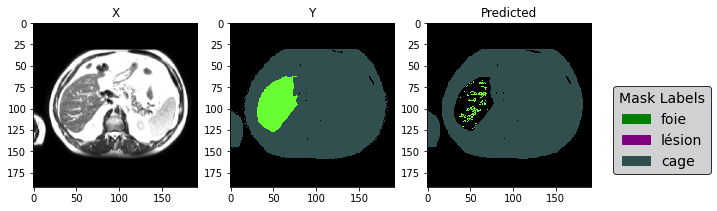

229


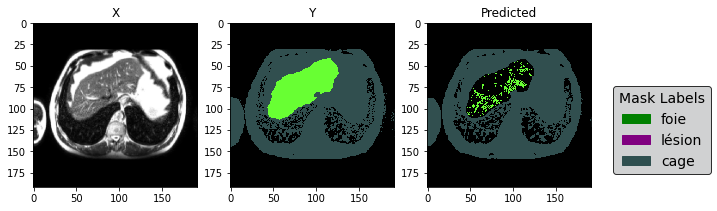

285


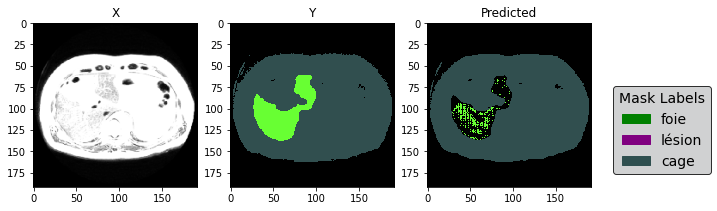

232


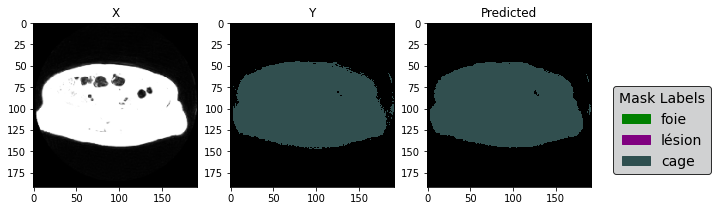

67


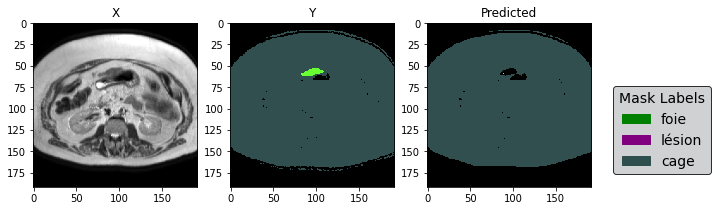

46


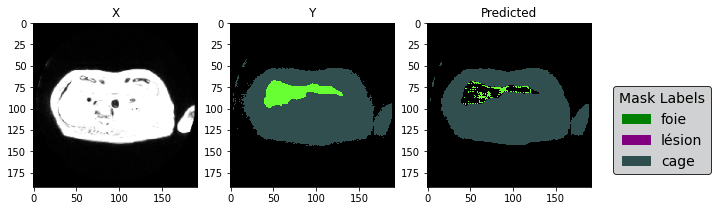

478


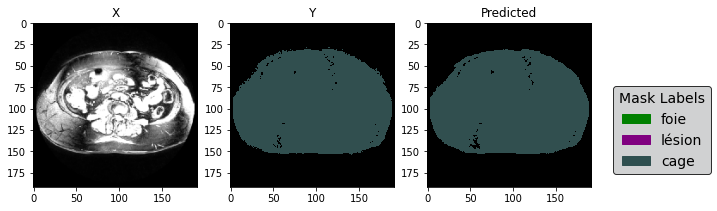

18


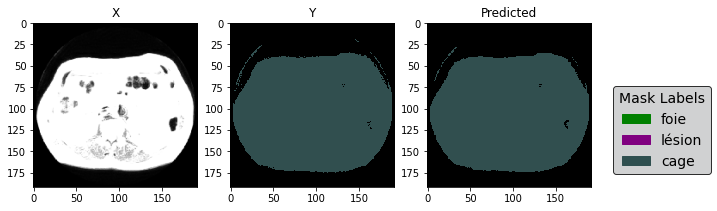

789


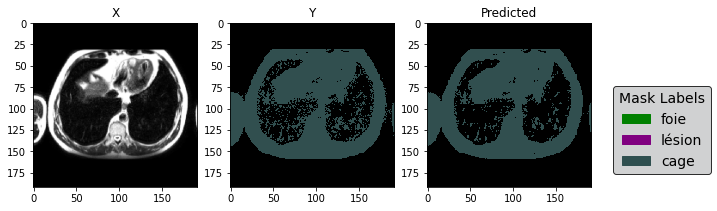

872


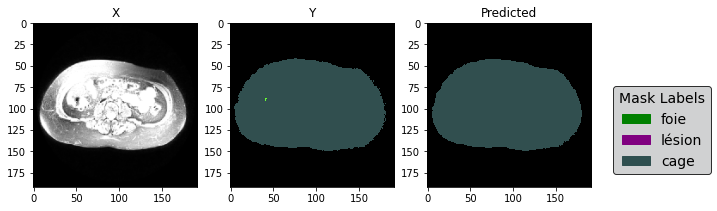

579


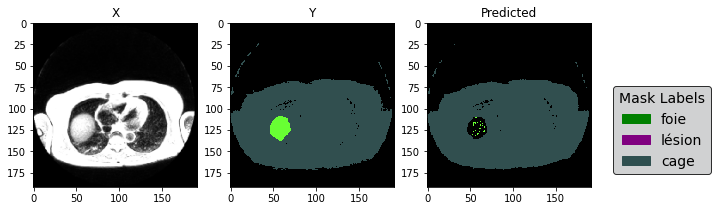

44


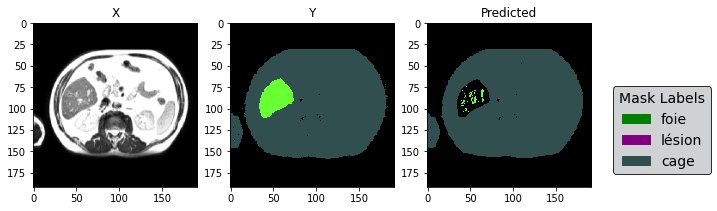

379


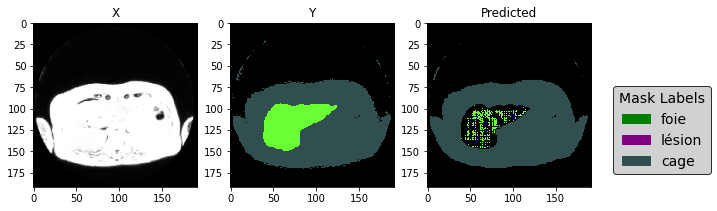

810


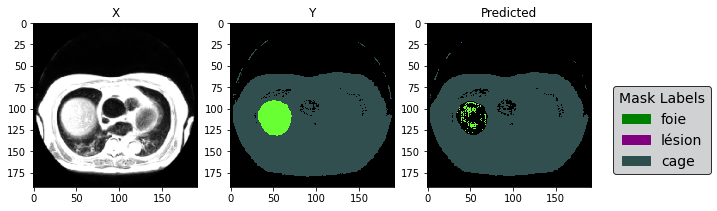

425


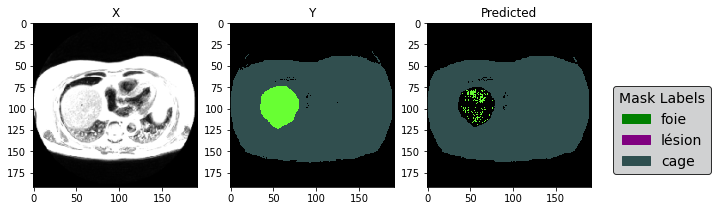

649


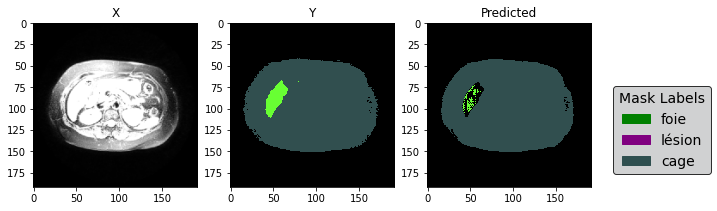

800


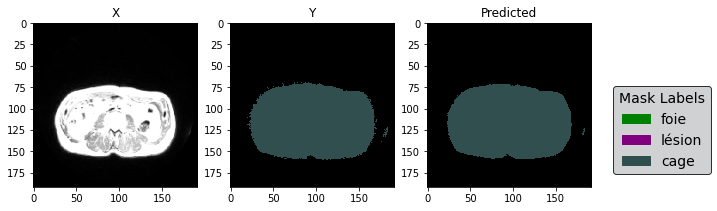

660


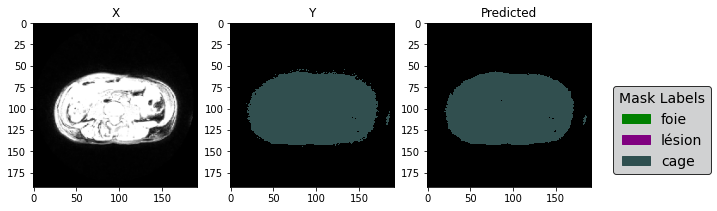

672


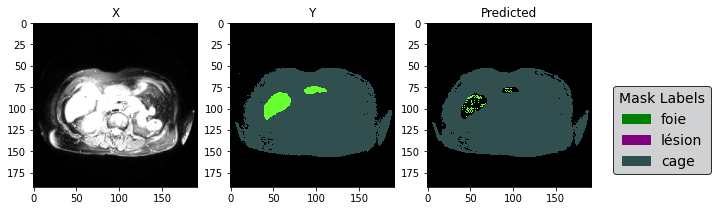

199


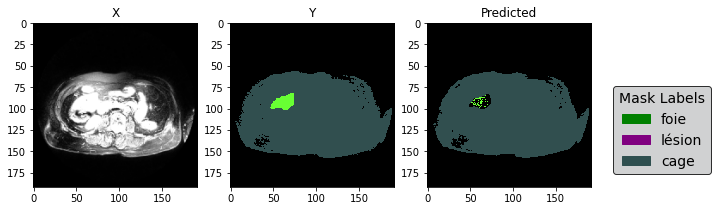

766


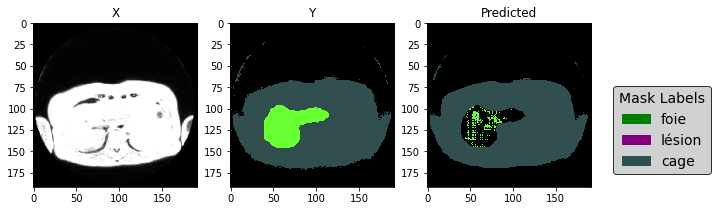

497


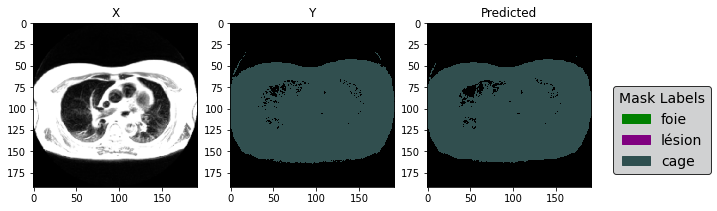

375


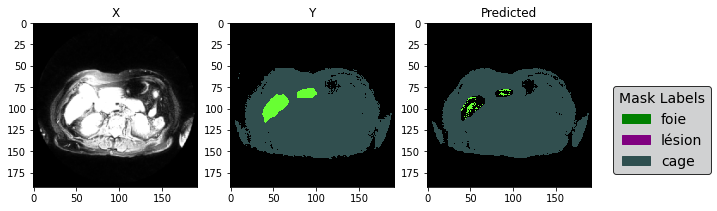

521


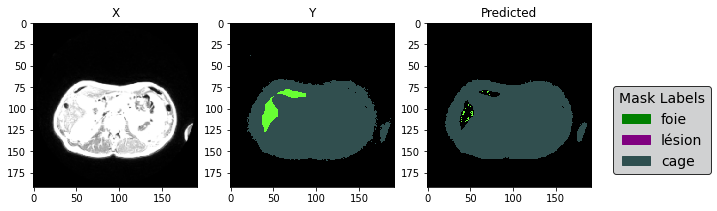

886


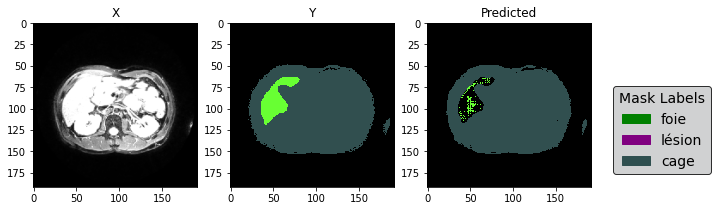

In [58]:
# Check if training data looks all right
for j in range(25):
  i = random.randint(0,preds_train1.shape[0])
  print(i)
  plot_sample(X_train, y_train, preds_train1, ix=i)
  plt.show()
  # if i >15:
  #   break

In [ ]:
plot_sample(X_train, y_train, preds_train1)

## Predictions on test set

215


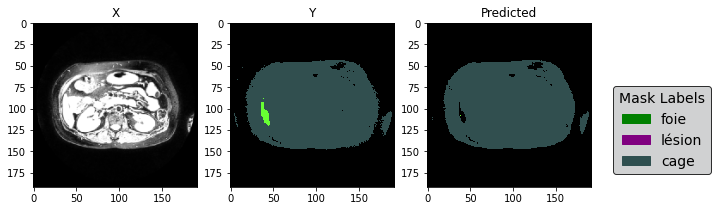

160


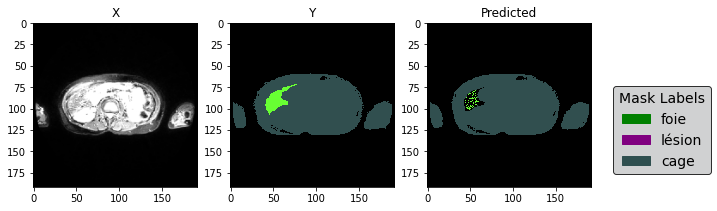

117


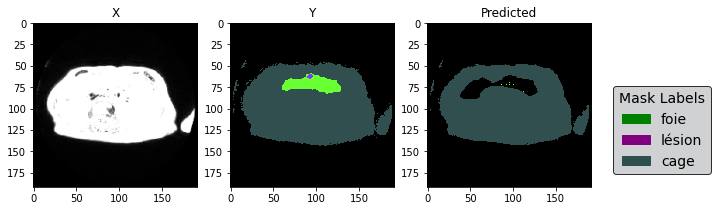

41


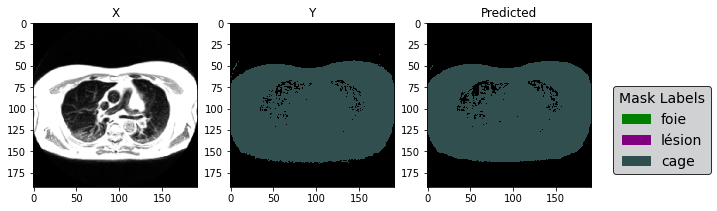

109


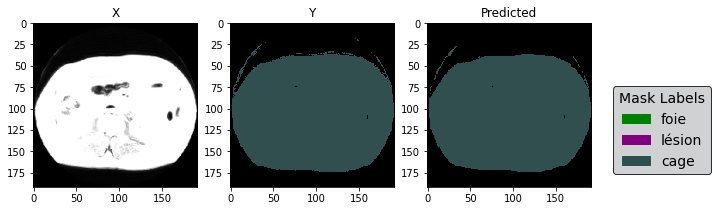

37


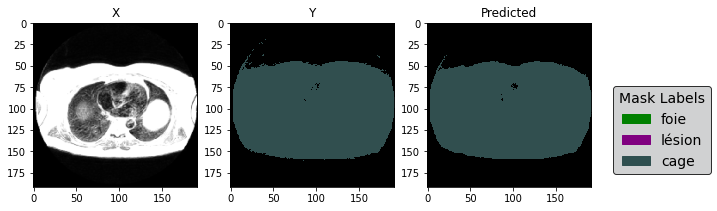

75


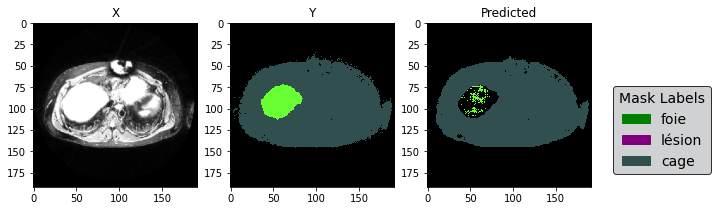

127


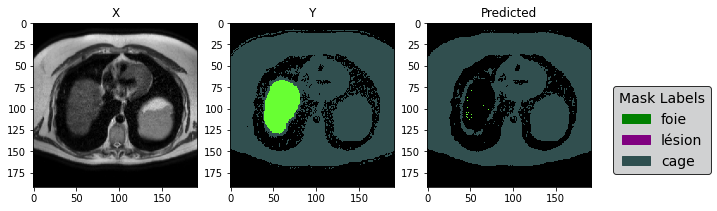

63


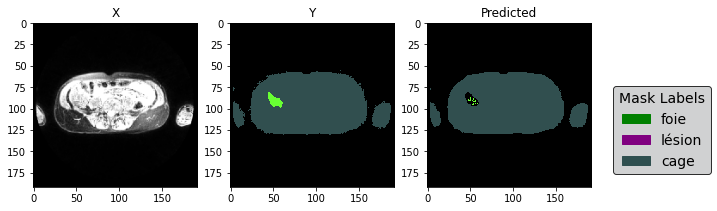

198


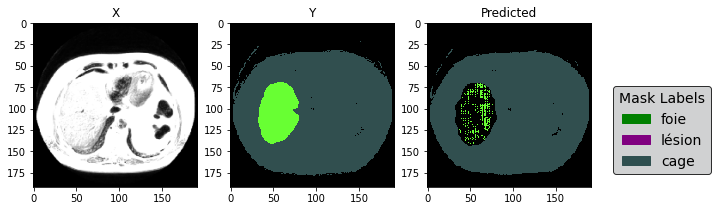

113


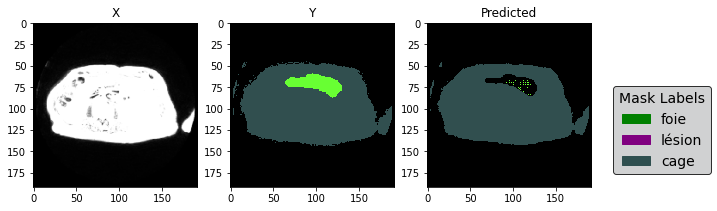

105


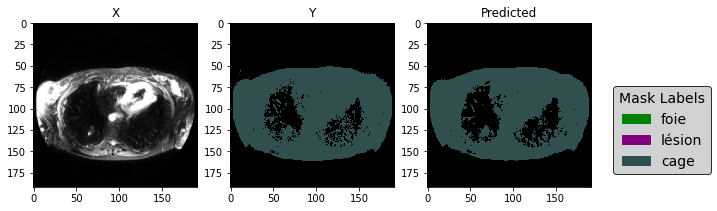

59


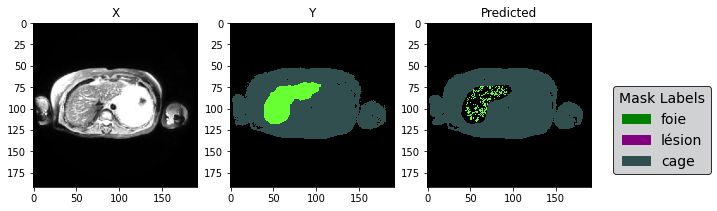

200


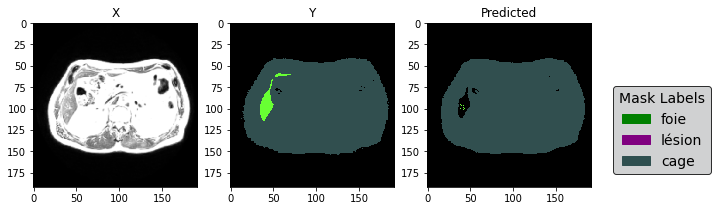

167


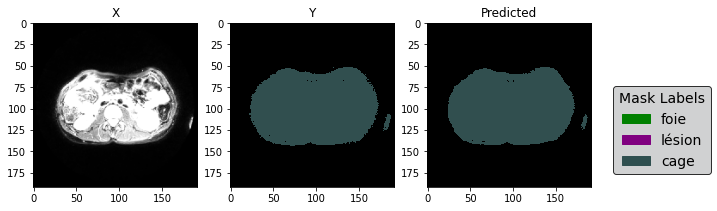

170


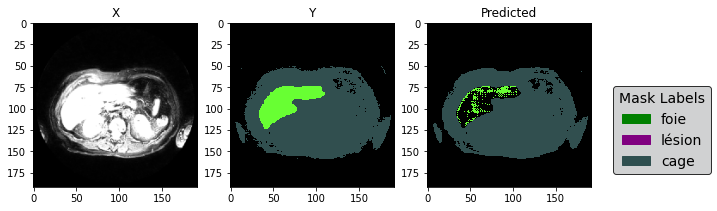

71


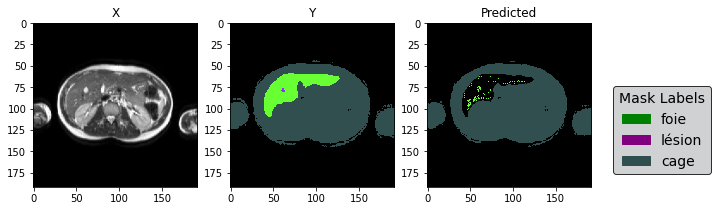

36


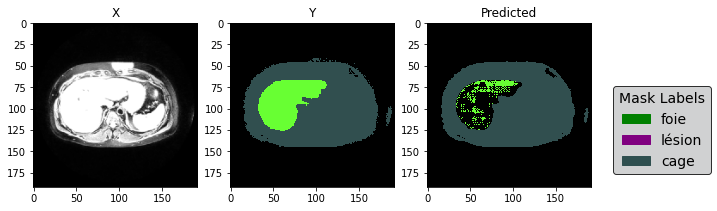

189


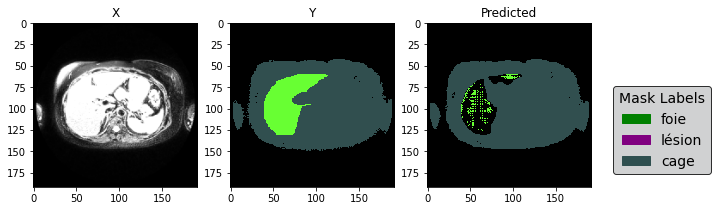

1


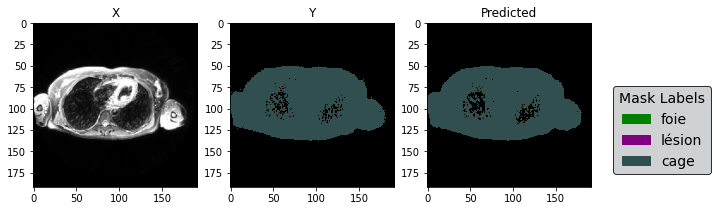

158


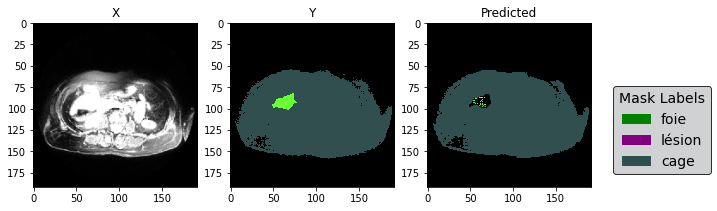

26


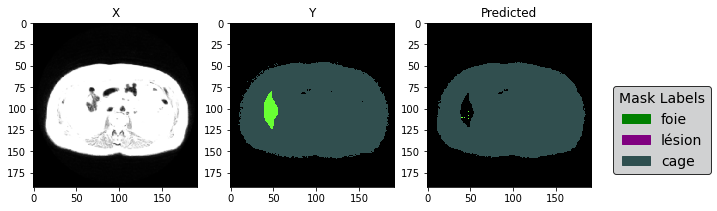

23


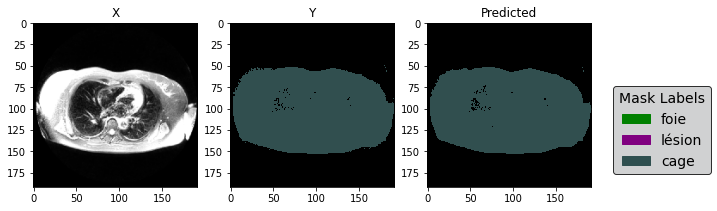

21


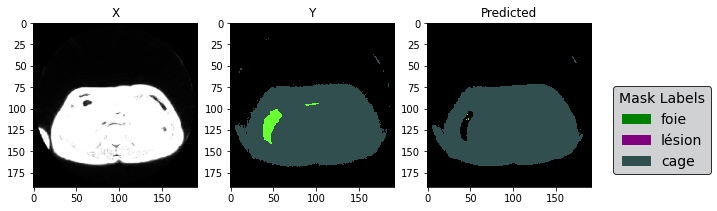

135


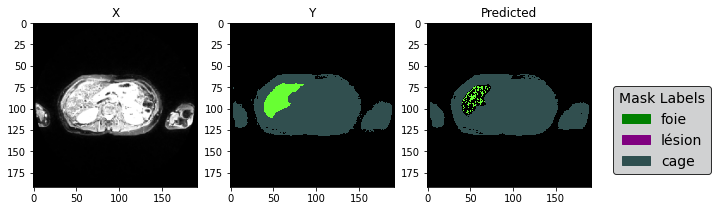

In [57]:
# Check if valid data looks all right
for j in range(25):
  i = random.randint(0,preds_val1.shape[0])
  print(i)
  plot_sample(X_valid, y_valid, preds_val1, ix=i)
  plt.show()
  # if i > int(preds_val1.shape[0]/10):
  #   break

In [ ]:
plot_sample(X_valid, y_valid, preds_val1)